In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.autograd as autograd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)
        # alpha = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1])[0][:, 1:n+1, 0]
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

Text(0, 0.5, 'Relative residual')

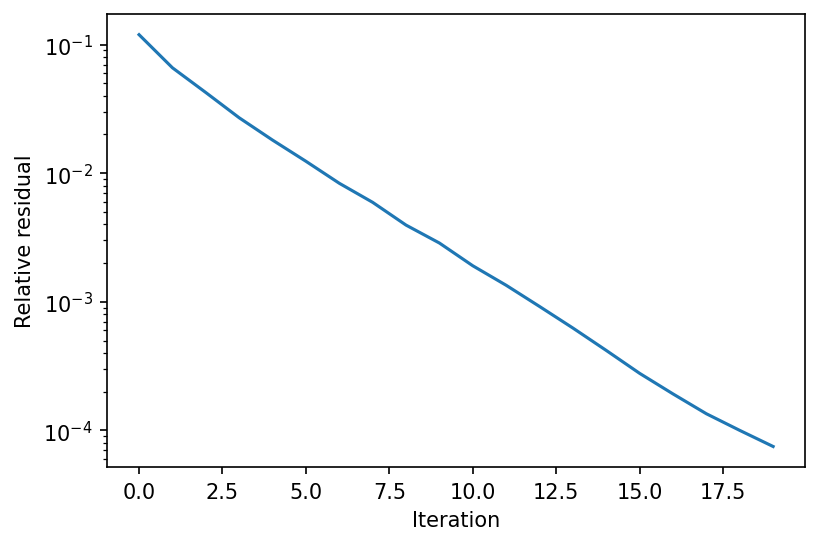

In [7]:
X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
Z, res = anderson(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

In [3]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

########################################################################
#Defining the FNO

torch.manual_seed(0)
np.random.seed(0)

################################################################
# Spectral Convolution Layers 
# 1D and 2D
################################################################

class fourier_conv_1d(nn.Module):
  def __init__(self, in_, out_, wavenumber1):
    super(fourier_conv_1d, self).__init__()
    self.in_ = in_
    self.out_ = out_
    self.wavenumber1 = wavenumber1
    self.scale = (1 / (in_ * out_))
    self.weights1 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, dtype=torch.cfloat))
   
    # Complex multiplication
  def compl_mul1d(self, input, weights):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum("bix,iox->box", input, weights)

  def forward(self, x):
    batchsize = x.shape[0]
    #Compute Fourier coeffcients up to factor of e^(- something constant)
    x_ft = torch.fft.rfft(x)

    # Multiply relevant Fourier modes
    out_ft = torch.zeros(batchsize, self.out_, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
    out_ft[:, :, :self.wavenumber1] = self.compl_mul1d(x_ft[:, :, :self.wavenumber1], self.weights1)

    #Return to physical space
    x = torch.fft.irfft(out_ft, n=x.size(-1))
    return x

  def print(self):
    return f'FourierConv1d({self.in_}, {self.out_}, wavenumber={self.wavenumber1})'

class fourier_conv_2d(nn.Module):
  def __init__(self, in_, out_, wavenumber1, wavenumber2):
    super(fourier_conv_2d, self).__init__()
    self.in_ = in_
    self.out_ = out_
    self.wavenumber1 = wavenumber1
    self.wavenumber2 = wavenumber2
    self.scale = (1 / (in_ * out_))
    self.weights1 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, self.wavenumber2, dtype=torch.cfloat))
    self.weights2 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, self.wavenumber2, dtype=torch.cfloat))

    # Complex multiplication
  def compl_mul2d(self, input, weights):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    return torch.einsum("bixy,ioxy->boxy", input, weights)

  def forward(self, x):
    batchsize = x.shape[0]
    #Compute Fourier coeffcients up to factor of e^(- something constant)
    x_ft = torch.fft.rfft2(x)
    # Multiply relevant Fourier modes
    out_ft = torch.zeros(batchsize, self.in_,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
    out_ft[:, :, :self.wavenumber1, :self.wavenumber2] = \
        self.compl_mul2d(x_ft[:, :, :self.wavenumber1, :self.wavenumber2], self.weights1)
    out_ft[:, :, -self.wavenumber1:, :self.wavenumber2] = \
        self.compl_mul2d(x_ft[:, :, -self.wavenumber1:, :self.wavenumber2], self.weights2)
    #Return to physical space
    x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
    return x

  def print(self):
    return f'FourierConv2d({self.in_}, {self.out_}, wavenumber={self.wavenumber1, self.wavenumber2})'

################################################################
# Fourier Layer 
################################################################
class Fourier_layer(nn.Module):
  def __init__(self,  features_, wavenumber, activation = 'relu', is_last = False):
    super(Fourier_layer, self).__init__()
    self.is_last = is_last
    self.activation = activation.lower()
    self.dim = len(wavenumber)
    self.W =  nn.Conv1d(features_, features_, 1) if self.dim==1 else nn.Conv2d(features_, features_, 1)
    self.fourier_conv = self.set_conv_dim()
    self.nonlinear = set_activ(activation)

  def set_conv_dim(self):
    if self.dim== 1:
      return  fourier_conv_1d(features_, features_, *wavenumber)
    elif self.dim== 2:
      return  fourier_conv_2d(features_, features_, *wavenumber)
   
  def forward(self, x):
        x1 = self.fourier_conv(x)
        x2 = self.W(x)
        x = x1 + x2
        if self.is_last == True:
          return x
        else:
          x = self.nonlinear(x)
          return x
            
  def __repr__(self):
    with torch.no_grad():
      return self.activation+'('+self.fourier_conv.print() +' + '+ self.W.__repr__()+')'

################################################################
# Lifting map
################################################################

class Lifting(nn.Module):
  def __init__(self, input, width, activation):
    super().__init__()
    self.fc1 = nn.Linear(input, width//2)
    self.nonlinear =set_activ(activation)
    self.fc2 = nn.Linear(width//2, width)
  def forward(self,x):
    x = self.fc1(x)
    x = self.nonlinear(x)
    x = self.fc2(x)
    return x

################################################################
# Projection map
################################################################

class Proj(nn.Module):
  def __init__(self,width1, width2, activation):
    super().__init__()
    self.fc1 = nn.Linear(width1, width2)
    self.fc2 = nn.Linear(width2, 1)
    self.nonlinear =set_activ(activation)
  def forward(self,x):
    x = self.fc1(x)
    x = self.nonlinear(x)
    x = self.fc2(x)
    return x
################################################################
# FNO
################################################################

class FNO(nn.Module):
  def __init__(self, wavenumber, 
                    features_, layers, 
                    padding = 9, 
                    activation= 'relu'):
    super(FNO, self).__init__()
    self.dim = len(wavenumber)
    self.activation = activation.lower() 
    self.padding = padding   
    self.features_ =features_
    self.layers = layers
    self.lifting = Lifting(self.dim+1, self.features_, activation= self.activation)
    self.fno = []
    self.proj = Proj(self.features_, 128, self.activation)

    for l in range(layers-1):
      self.fno.append(Fourier_layer(features_ =features_, 
                                    wavenumber=wavenumber, 
                                    activation = activation))
      
    self.fno.append(Fourier_layer(features_=features_, 
                                    wavenumber=wavenumber, 
                                    activation = activation,
                                    is_last= True))
    self.fno =nn.Sequential(*self.fno)

  def forward(self, x):
    grid = self.get_grid2D(x.shape, x.device) if self.dim == 2 else self.get_grid1D(x.shape, x.device)
    x = torch.cat((x, grid), dim=-1)
    ####Lifting Map 
    x = self.lifting(x)
    ###Actual Neural Operator
    x = x.permute(0, 3, 1, 2) if self.dim == 2 else x.permute(0, 2, 1)
    x = F.pad(x, [0,self.padding, 0,self.padding]) if self.dim == 2 else F.pad(x, [0,self.padding])
    x = self.fno(x)
    x = x[..., :-self.padding, :-self.padding] if self.dim == 2 else x[..., :-self.padding]
    x = x.permute(0, 2, 3, 1) if self.dim == 2 else x.permute(0, 2, 1)
    ####Projection Map
    x =self.proj(x)
    return x
    
  def get_grid2D(self, shape, device):
    batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    return torch.cat((gridx, gridy), dim=-1).to(device)

  def get_grid1D(self, shape, device):
    batchsize, size_x = shape[0], shape[1]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
    return gridx.to(device)

class FNO_DEQ(nn.Module):
  def __init__(self, wavenumber, 
                    features_, 
                    padding = 9, 
                    activation= 'relu'):
    super(FNO, self).__init__()
    self.dim = len(wavenumber)
    self.activation = activation.lower() 
    self.padding = padding   
    self.features_ =features_
    self.lifting = Lifting(self.dim+1, self.features_, activation= self.activation)
    self.fno = [Fourier_layer(features_ =features_, wavenumber=wavenumber, activation = activation)]
    self.proj = Proj(self.features_, 128, self.activation)
      
    self.fno.append(Fourier_layer(features_=features_, 
                                    wavenumber=wavenumber, 
                                    activation = activation,
                                    is_last= True))
    self.fno =nn.Sequential(*self.fno)

  def forward(self, x):
    grid = self.get_grid2D(x.shape, x.device) if self.dim == 2 else self.get_grid1D(x.shape, x.device)
    x = torch.cat((x, grid), dim=-1)
    ####Lifting Map 
    x = self.lifting(x)
    ###Actual Neural Operator
    x = x.permute(0, 3, 1, 2) if self.dim == 2 else x.permute(0, 2, 1)
    x = F.pad(x, [0,self.padding, 0,self.padding]) if self.dim == 2 else F.pad(x, [0,self.padding])
    x = self.fno(x)
    x = x[..., :-self.padding, :-self.padding] if self.dim == 2 else x[..., :-self.padding]
    x = x.permute(0, 2, 3, 1) if self.dim == 2 else x.permute(0, 2, 1)
    ####Projection Map
    x =self.proj(x)
    return x
    
  def get_grid2D(self, shape, device):
    batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    return torch.cat((gridx, gridy), dim=-1).to(device)

  def get_grid1D(self, shape, device):
    batchsize, size_x = shape[0], shape[1]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
    return gridx.to(device)

################################################################
# Miscellaneous
################################################################

def set_activ(activation):
  with torch.no_grad():
    if activation == 'relu':
      nonlinear = F.relu
    elif activation == 'tanh':
      nonlinear = nn.Tanh()
    elif activation == 'sine':
      nonlinear= torch.sin
    elif activation == 'gelu':
      nonlinear= F.gelu
    elif activation == None:
      nonlinear = lambda a : a
    else:
      raise Exception('The activation is not recognized from the list')
    return nonlinear

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
PATH = '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator'
os.chdir(PATH)
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator/Notebooks')
from utils import *
from Adam import * 
from FNO import FNO

Mounted at /content/drive


In [12]:
################################################################
# load data and data normalization
################################################################
EqFile = 'DarcyFlow'
PDE_dir =  os.path.join(PATH, 'data', EqFile)
x_train = torch.load( os.path.join(PDE_dir, f'{EqFile}_x_train.pt'))
y_train = torch.load(os.path.join(PDE_dir, f'{EqFile}_y_train.pt'))
x_test = torch.load(os.path.join(PDE_dir, f'{EqFile}_x_test.pt'))
y_test= torch.load(os.path.join(PDE_dir, f'{EqFile}_y_test.pt'))

In [13]:
#Parameters
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
s = x_test.shape[-2]
batch_size = 20
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
#x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,s,1)
#x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

loss_train = []
loss_test =  []
epoch_vec = []

#NN parameters
activ_vec = ['relu', 'tanh', 'sine', 'gelu']
activ = activ_vec[0]
layers = 5
learning_rate = 0.001

epochs = 100
step_size = epochs//5
gamma = 0.5

wavenumber = [12, 12]
features_ = 32

In [14]:
model = FNO(wavenumber = wavenumber,features_ =features_, layers =4, activation = activ_vec[-1]).to(device)
model

FNO(
  (lifting): Lifting(
    (fc1): Linear(in_features=3, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
  )
  (proj): Proj(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
  (fno): Sequential(
    (0): gelu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (1): gelu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (2): gelu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (3): gelu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
  )
)

In [17]:
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
y_normalizer.to(device)

################################################################
# training and evaluation
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        #out = model(x).reshape(batch_size, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()
    
    epoch_vec.append(ep)
    #e= epoch_vec[-1]
    #epoch_vec.append(e+1)
    
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
    
            out = model(x).reshape(batch_size, s, s)
            #out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    loss_train.append(train_l2)
    loss_test.append(test_l2)

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

1188833
0 2.8687319059999936 0.18285265779495238 0.11662769556045532
1 2.2723624239999936 0.11013763070106507 0.11188261032104492
2 2.2795983350001734 0.10199408614635468 0.09975797891616821


KeyboardInterrupt: ignored